In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

### Mount the Google drive if needed

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'neuralDDE_ROM_Closure'))

### Load modules

In [3]:
from src.utilities.DDE_Solver import ddeinttf 
import src.solvers.neuralDDE_with_adjoint as ndde
import src.advec_diff_case.advec_diff_eqn as adeq

import time
import sys
from IPython.core.debugger import set_trace

import numpy as np
import scipy as spy
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from shutil import move

tf.keras.backend.set_floatx('float32')
import logging
tf.get_logger().setLevel(logging.ERROR)

## Define some useful classes

### Class for user-defined arguments

In [4]:
class res_ad_eq_nDDE_args(ndde.arguments, adeq.ad_eqn_args):

    def __init__(self, batch_time = 12, batch_time_skip = 2, batch_size = 5, epochs = 500, learning_rate = 0.05, decay_rate = 0.95, test_freq = 1, plot_freq = 2, 
                 d_max = 1.1, rnn_nmax = 3, rnn_dt = 0.5, state_dim = 2, adj_data_size = 2,
                 model_dir = 'ROM_nODE_testcase/model_dir_test', restart = 0, val_percentage = 0.2,
                 T = 2., nt = 200, L = 1., nx_high_res = 100, nx_low_res = 25, Re = 250, u_bc_0 = 0., u_bc_L =0., isplot = True, reg_coeff = 0.001): # add more arguments as needed
        
        ndde.arguments.__init__(self, data_size = nt, batch_time = batch_time, batch_time_skip = batch_time_skip, batch_size = batch_size, epochs = epochs,
                           learning_rate = learning_rate, decay_rate = decay_rate, test_freq = test_freq, plot_freq = plot_freq, d_max = d_max, rnn_nmax = rnn_nmax, 
                           rnn_dt = rnn_dt, state_dim = nx_low_res, adj_data_size = nx_low_res, model_dir = model_dir, restart = restart, val_percentage = val_percentage, isplot = isplot)

        adeq.ad_eqn_args.__init__(self, T = T, nt = nt, L = L, nx = nx_low_res, Re = Re, u_bc_0 = u_bc_0, u_bc_L = u_bc_L,
                              multi_solve_size = batch_size)
        
        self.args_for_high_res = adeq.ad_eqn_args(T = T, nt = nt, L = L, nx = nx_high_res, Re = Re, u_bc_0 = u_bc_0, u_bc_L = u_bc_L, 
                              multi_solve_size = 1)
        
        self.args_for_low_res = adeq.ad_eqn_args(T = T, nt = nt, L = L, nx = nx_low_res, Re = Re, u_bc_0 = u_bc_0, u_bc_L = u_bc_L, 
                              multi_solve_size = 1)
        
        self.nx_high_res = nx_high_res
        self.nx_low_res = nx_low_res
        self.reg_coeff = reg_coeff

### Define the neural net architecture

In [5]:
def interp_high_res_to_low_res(u_high_res, x_high_res, x_low_res, t):

    f = spy.interpolate.interp2d(x_high_res, t, tf.squeeze(u_high_res, axis=1).numpy(), kind='cubic')

    u_interp = tf.expand_dims(tf.convert_to_tensor(f(x_low_res, t), dtype=tf.float32), axis=1)

    return u_interp

### Define a custom loss function

### Define a custom plotting function

In [24]:
class custom_plot:

    def __init__(self, true_y, y_no_nn, x, t, args):
        self.true_y = true_y
        self.y_no_nn = y_no_nn
        self.t = t
        self.args = args
        self.X, self.T = np.meshgrid(x.numpy(), t.numpy())
        self.x = x

    def plot(self, *pred_y):
        fig = plt.figure(figsize=(14, 4.5), facecolor='white')
        ax_u_nn = fig.add_subplot(121, projection='3d')
        ax_u_diff_nn = fig.add_subplot(122, projection='3d')

        
        ax_u_nn.cla()
        ax_u_nn.set_title('Low-Res with nCM Solution', fontsize=14)
        ax_u_nn.set_xlabel('x', fontsize=14)
        ax_u_nn.set_ylabel('t', fontsize=14)
        ax_u_nn.set_zlabel('u', fontsize=14)
        plot = ax_u_nn.plot_surface(self.X, self.T, tf.squeeze(pred_y[0], axis=1).numpy(), cmap=cm.coolwarm,
                            linewidth=0, antialiased=False, vmin=0, vmax=0.45)
        ax_u_nn.set_xlim(self.x[0], self.x[-1])
        ax_u_nn.set_ylim(self.t[0], self.t[-1])
        ax_u_nn.set_zlim(0., 0.5)
        plt.colorbar(plot, ax=ax_u_nn, shrink=0.5, aspect=10)

        ax_u_diff_nn.cla()
        ax_u_diff_nn.set_title('|Difference|', fontsize=14)
        ax_u_diff_nn.set_xlabel('x', fontsize=14)
        ax_u_diff_nn.set_ylabel('t', fontsize=14)
        ax_u_diff_nn.set_zlabel('u', fontsize=14)
        plot = ax_u_diff_nn.plot_surface(self.X, self.T, tf.abs(tf.squeeze(self.true_y - pred_y[0], axis=1)).numpy(), cmap=plt.get_cmap('coolwarm'),
                            linewidth=0, antialiased=False,vmin=0, vmax=0.45)
        ax_u_diff_nn.set_xlim(self.x[0], self.x[-1])
        ax_u_diff_nn.set_ylim(self.t[0], self.t[-1])
        ax_u_diff_nn.set_zlim(0., 0.5)
        plt.colorbar(plot, ax=ax_u_diff_nn, shrink=0.5, aspect=10)

        plt.show() 
        
    def plot_contour(self, *pred_y):
        fig = plt.figure(figsize=(14, 4.5), facecolor='white')
        ax_u_nn = fig.add_subplot(121)
        ax_u_diff_nn = fig.add_subplot(122)

        
        ax_u_nn.cla()
        ax_u_nn.set_title('Low-Res with nCM Solution', fontsize=14)
        ax_u_nn.set_xlabel('x', fontsize=14)
        ax_u_nn.set_ylabel('t', fontsize=14)
        plot = ax_u_nn.contourf(self.X, self.T, tf.squeeze(pred_y[0], axis=1).numpy(), cmap=cm.coolwarm,
                           antialiased=False, levels=np.linspace(0, 0.5, 20), extend='min')
        ax_u_nn.set_xlim(self.x[0], self.x[-1])
        ax_u_nn.set_ylim(self.t[0], self.t[-1])
        plt.colorbar(plot, ax=ax_u_nn, shrink=0.5, aspect=10)

        ax_u_diff_nn.cla()
        ax_u_diff_nn.set_title('|Difference|', fontsize=14)
        ax_u_diff_nn.set_xlabel('x', fontsize=14)
        ax_u_diff_nn.set_ylabel('t', fontsize=14)
        plot = ax_u_diff_nn.contourf(self.X, self.T, tf.abs(tf.squeeze(self.true_y - pred_y[0], axis=1)).numpy(), cmap=plt.get_cmap('coolwarm'),
                            antialiased=False, levels=np.linspace(0, 0.25, 20))
        ax_u_diff_nn.set_xlim(self.x[0], self.x[-1])
        ax_u_diff_nn.set_ylim(self.t[0], self.t[-1])
        plt.colorbar(plot, ax=ax_u_diff_nn, shrink=0.5, aspect=10)

        plt.show() 

### Initial Conditions

In [7]:
class initial_cond:

    def __init__(self, x, app):
        self.x = x
        self.app = app

    def __call__(self, t):
        u0 = self.x / (1. + np.sqrt(1./self.app.t0) * np.exp(self.app.Re * self.x**2 / 4., dtype = np.float64))
        return tf.convert_to_tensor([u0], dtype=tf.float32)

### Initialize model related parameters

In [8]:
args = res_ad_eq_nDDE_args(batch_time = 6, batch_time_skip = 2, batch_size = 8, epochs = 500, learning_rate = 0.075, decay_rate = 0.97, test_freq = 1, plot_freq = 2,
                    d_max = 0.1, rnn_nmax = 3, rnn_dt = 0.025, model_dir = 'Res_nDDE_testcase/model_dir_case9', restart = 0, val_percentage = 1.,
                    T = 1.25, nt = 125, L = 1., nx_high_res = 100, nx_low_res = 25, Re = 1000, u_bc_0 = 0., u_bc_L =0., reg_coeff = 0.0)

### Copy the NN architecture from the save directory

In [9]:
class DDEFunc(tf.keras.Model):

    def __init__(self, gov_model, **kwargs):
        super(DDEFunc, self).__init__(**kwargs)

        self.rnn_layer = tf.keras.layers.RNN(tf.keras.layers.SimpleRNNCell(10, activation='tanh', use_bias=True, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), 
                                                                        recurrent_initializer='random_normal'))
        
        self.x1 = tf.keras.layers.Dense(10, activation='tanh',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.out = tf.keras.layers.Dense(args.state_dim, activation='linear',
                                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.gov_model = gov_model


    def call(self, y, t, d):
        input = []
        for i in np.flip(np.arange(d[0])): # d is a list and d[0] contains the number of steps, while d[1] contains the time-step value to skip
            input.append(tf.expand_dims(y(t - i*d[1]), axis=0))

        input = tf.concat(input, axis=0)
        input = tf.transpose(input, perm=[1, 0] + [i for i in range(2, input.shape.rank)])
        y_nn = input
        for i in range(len(self.layers)):
            y_nn = self.layers[i](y_nn)
        return y_nn + self.gov_model(y, t) + args.reg_coeff * tf.random.normal([y_nn.shape[0], args.state_dim])

In [10]:
os.chdir(basedir)

checkpoint_dir = os.path.join(args.model_dir, "ckpt")
checkpoint_prefix = os.path.join(checkpoint_dir, "cp-{epoch:04d}.ckpt")

### Solve for the high resolution model

In [11]:
x_high_res = tf.linspace(0., args.L, args.nx_high_res)
t = tf.linspace(0., args.T, args.nt) # Time array

u0 = initial_cond(x_high_res, args.args_for_high_res) # Initial conditions

op = adeq.operators(args.args_for_high_res)

u_high_res = ddeinttf(adeq.ad_eqn(op), u0, t)

# Compute FOM for the validation time
dt = t[1] - t[0]
val_t_len =  args.val_percentage * (t[-1] - t[0])
n_val = np.ceil(np.abs(val_t_len/dt.numpy())).astype(int)
val_t = tf.linspace(t[-1], t[-1] + val_t_len, n_val)

val_u_high_res = ddeinttf(adeq.ad_eqn(op), ndde.create_interpolator(u_high_res, t), val_t)

print('High resolution model done!')

High resolution model done!


### Solve for low resolution model

In [12]:
x_low_res = tf.linspace(0., args.L, args.nx_low_res)

u0 = initial_cond(x_low_res, args.args_for_low_res) # Initial conditions

op = adeq.operators(args.args_for_low_res)

u_low_res = ddeinttf(adeq.ad_eqn(op), u0, t)

val_u_low_res = ddeinttf(adeq.ad_eqn(op), ndde.create_interpolator(u_low_res, t), val_t)

print('Low resolution model done!')

Low resolution model done!


In [13]:
# Interpolate high resolution solution on low resolution grid

true_u_low_res = interp_high_res_to_low_res(u_high_res, x_high_res, x_low_res, t)

val_true_u_low_res = interp_high_res_to_low_res(val_u_high_res, x_high_res, x_low_res, val_t)

## Main part starts here

### Make objects and define learning-rate schedule

In [14]:
func = DDEFunc(adeq.ad_eqn(op = adeq.operators(args)))
val_obj = ndde.create_validation_set(u0, t, args)

### Plot training time

In [15]:
func.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
pred_y = ddeinttf(func, u0, tf.concat([t, val_t], axis=0), fargs=([args.rnn_nmax, args.rnn_dt],))

In [25]:
plot_obj = custom_plot(tf.concat([true_u_low_res, val_true_u_low_res], axis=0), 
                       tf.concat([u_low_res, val_u_low_res], axis=0), x_low_res, tf.concat([t, val_t], axis=0), args)

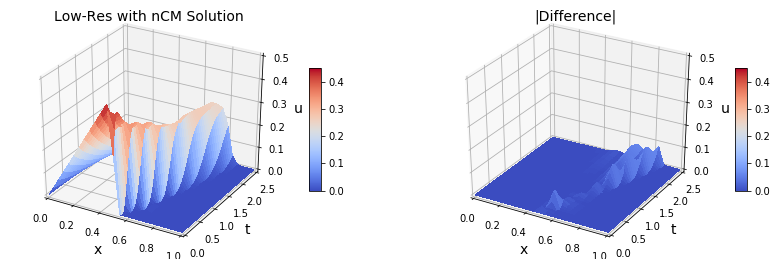

In [26]:
plot_obj.plot(pred_y)

#### Make contour plots

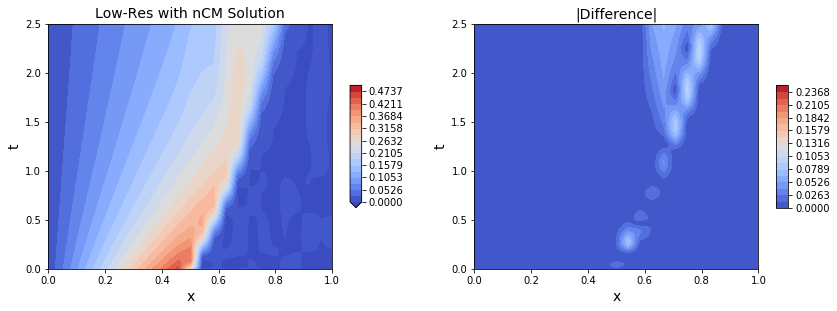

In [23]:
plot_obj.plot_contour(pred_y)

### Print the network architecture

In [17]:
func.summary()

Model: "dde_func"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (RNN)                    multiple                  360       
_________________________________________________________________
dense (Dense)                multiple                  110       
_________________________________________________________________
dense_1 (Dense)              multiple                  275       
Total params: 745
Trainable params: 745
Non-trainable params: 0
_________________________________________________________________


### Compute the time-averaged L2 error for the prediction

In [27]:
tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.math.squared_difference(pred_y, tf.concat([true_u_low_res, val_true_u_low_res], axis=0)), axis=-1)), axis=0)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.06448852], dtype=float32)>

### Compute time-averaged RMSE for points with error above a threshold for prediction

In [32]:
thres = tf.reduce_max(true_u_low_res)*0.02
error = []
diff = pred_y - tf.concat([true_u_low_res, val_true_u_low_res], axis=0)

for i in range(1, pred_y.shape[0]):
    diff_t = np.abs(np.squeeze(diff[i, :, :].numpy()))
    error_t = diff_t[np.where(diff_t >= thres)]
    if len(error_t) == 0: continue
    error_t = np.sqrt(np.sum(error_t**2)/len(error_t))
    error.append(error_t)
    
np.mean(np.array(error))

0.03715117843997743